In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [ ]:
! pip uninstall tensorflow==2.17.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.1


In [ ]:
!pip install tensorflow==2.8.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 42.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

# Model 2: Multivariate-5-RNN









In [ ]:
import sys
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
print(tf.__version__)


2.8.4


In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'FPT.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


<Axes: >

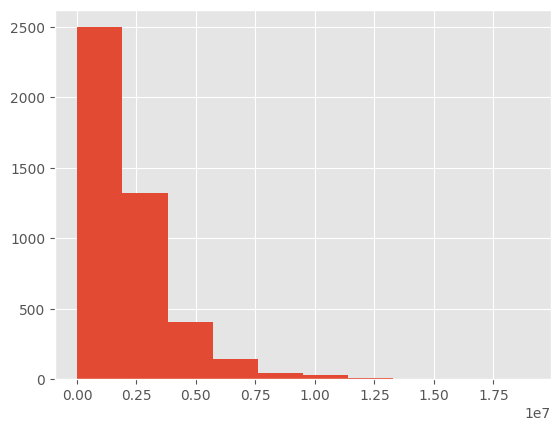

In [ ]:
# Distribution of Various Features
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
print(df.head())

               Open     High      Low    Close     Volume  CMA10  SMA10  \
Date                                                                      
2006-12-14  17021.1  17021.1  17021.1  17021.1  4020000.0    NaN    NaN   
2006-12-15  17872.1  17872.1  17872.1  17872.1  3800000.0    NaN    NaN   
2006-12-18  18763.7  18763.7  18763.7  18763.7  3090000.0    NaN    NaN   
2006-12-19  19695.8  19695.8  19695.8  19695.8  1970000.0    NaN    NaN   
2006-12-20  20668.4  20668.4  20668.4  20668.4  3150000.0    NaN    NaN   

            SMA50         EMA12         EMA26        MACD  RSI  CCI  %K  %D  
Date                                                                         
2006-12-14    NaN  17021.100000  17021.100000    0.000000  NaN  NaN NaN NaN  
2006-12-15    NaN  17152.023077  17084.137037   67.886040  NaN  NaN NaN NaN  
2006-12-18    NaN  17399.973373  17208.549108  191.424264  NaN  NaN NaN NaN  
2006-12-19    NaN  17753.177469  17392.789915  360.387554  NaN  NaN NaN NaN  
2006-1

## Train model

In [ ]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_2(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Evaluate Model

In [ ]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart

In [ ]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## Model building

In [ ]:
# Extracting the series
series = df[['Close','High','Low' , 'RSI', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4438, 5)
               Close      High       Low        RSI         MACD
Date                                                            
2024-10-21  135500.0  137700.0  135500.0  48.876404  1071.614461
2024-10-22  133100.0  135700.0  133000.0  44.162437   726.680320
2024-10-23  134200.0  134800.0  132600.0  50.515464   535.900804
2024-10-24  134300.0  134300.0  133800.0  50.515464   388.299749
2024-10-25  134000.0  134600.0  133600.0  49.746193   244.301205


In [ ]:
series.describe()

,Close,High,Low,RSI,MACD
count,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000
mean,29687.531929,30003.144772,29373.928526,52.719315,184.509707
std,31296.133210,31632.660635,30928.807651,18.142497,856.229145
min,2986.500000,3054.800000,2899.600000,0.000000,-5490.716253
25%,8504.900000,8586.500000,8407.700000,40.134926,-109.185986
50%,15245.400000,15416.100000,15124.350000,53.521524,84.346842
75%,33849.400000,34170.450000,33631.225000,65.741951,347.568182
max,146500.000000,146500.000000,143100.000000,100.000000,5341.049997


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3777]         # Next 463 rows for validation
test_data = series.iloc[3778:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 5) (660, 5) (660, 5)


,Close,High,Low,RSI,MACD
Date,,,,,
2007-01-03,18236.9,18236.9,17831.6,55.905611,362.298879
2007-01-04,19128.4,19128.4,19128.4,59.420121,385.141305
2007-01-05,20060.5,20060.5,20060.5,59.712237,473.004274
2007-01-08,19857.9,20668.4,19857.9,55.172446,520.290596
2007-01-09,19857.9,20060.5,19857.9,50.840323,551.409048


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 5) (660, 5) (660, 5)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 103: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 103: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 138: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 138: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 152: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 152: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 238: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 225: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 86: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 86: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 239: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 113: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 113: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 90: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 90: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 224: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.10577721695536829
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.016919  0.130072   
1          30  [40, 35]  0.0010          32         250  0.016919  0.130072   
2          30  [40, 35]  0.0010          64         200  0.037136  0.192707   
3          30  [40, 35]  0.0010          64         250  0.037136  0.192707   
4          30  [40, 35]  0.0001          32         200  0.071422  0.267250   
5          30  [40, 35]  0.0001          32         250  0.071422  0.267250   
6          30  [40, 35]  0.0001          64         200  0.043185  0.207809   
7          30  [40, 35]  0.0001          64         250  0.074052  0.272124   
8          40  [40, 35]  0.0010          32         200  1.461993  1.209129   
9          40  [40, 35]  0.0010          32         250  1.600766  1.26

In [ ]:
timesteps = 50
hl = [40,35]
lr = 1e-4
batch_size = 32
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


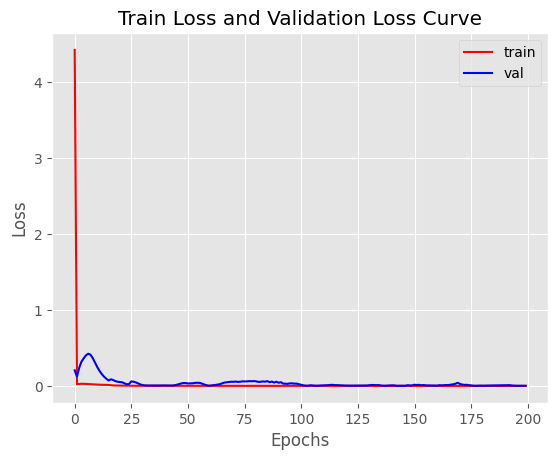

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.011188819626823054
RMSE = 0.10577721695536829
MAPE = 0.020460128216776712
R-Squared Score = 0.9891939040522616


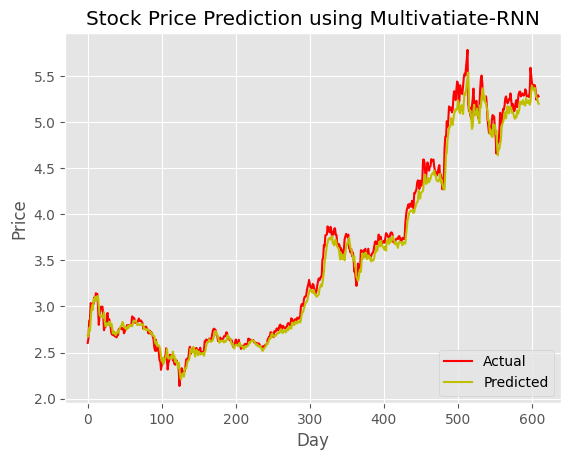

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 3: Multivariate-5-GRU


In [ ]:
import sys
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

##Data preprocessing

In [ ]:
url = 'FPT.csv'
df = pd.read_csv(url, parse_dates = True, index_col = 0)

In [ ]:
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
df.head()

,Open,High,Low,Close,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2006-12-14,17021.1,17021.1,17021.1,17021.1,4020000.0,NaN,NaN,NaN,17021.100000,17021.100000,0.000000,NaN,NaN,NaN,NaN
2006-12-15,17872.1,17872.1,17872.1,17872.1,3800000.0,NaN,NaN,NaN,17152.023077,17084.137037,67.886040,NaN,NaN,NaN,NaN
2006-12-18,18763.7,18763.7,18763.7,18763.7,3090000.0,NaN,NaN,NaN,17399.973373,17208.549108,191.424264,NaN,NaN,NaN,NaN
2006-12-19,19695.8,19695.8,19695.8,19695.8,1970000.0,NaN,NaN,NaN,17753.177469,17392.789915,360.387554,NaN,NaN,NaN,NaN
2006-12-20,20668.4,20668.4,20668.4,20668.4,3150000.0,NaN,NaN,NaN,18201.673243,17635.427699,566.245544,NaN,NaN,NaN,NaN


##Train Model


In [ ]:
def fit_model_3(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Evaluate Model


In [ ]:
def evaluate_model_3(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart


In [ ]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building


In [ ]:
# Extracting the series
series = df[['Close', 'High','Low', 'RSI','MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4438, 5)
               Close      High       Low        RSI         MACD
Date                                                            
2024-10-21  135500.0  137700.0  135500.0  48.876404  1071.614461
2024-10-22  133100.0  135700.0  133000.0  44.162437   726.680320
2024-10-23  134200.0  134800.0  132600.0  50.515464   535.900804
2024-10-24  134300.0  134300.0  133800.0  50.515464   388.299749
2024-10-25  134000.0  134600.0  133600.0  49.746193   244.301205


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3777]         # Next 463 rows for validation
test_data = series.iloc[3778:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 5) (660, 5) (660, 5)


,Close,High,Low,RSI,MACD
Date,,,,,
2007-01-03,18236.9,18236.9,17831.6,55.905611,362.298879
2007-01-04,19128.4,19128.4,19128.4,59.420121,385.141305
2007-01-05,20060.5,20060.5,20060.5,59.712237,473.004274
2007-01-08,19857.9,20668.4,19857.9,55.172446,520.290596
2007-01-09,19857.9,20060.5,19857.9,50.840323,551.409048


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 5) (660, 5) (660, 5)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 223: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 190: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 190: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 133: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 133: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 103: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 103: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 235: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 122: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 122: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 109: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 109: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 170: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 170: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 115: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 115: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 164: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 164: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 112: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 112: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.07784585193485223
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.006060  0.077846   
1          30  [40, 35]  0.0010          32         250  0.011917  0.109166   
2          30  [40, 35]  0.0010          64         200  0.095743  0.309423   
3          30  [40, 35]  0.0010          64         250  0.095743  0.309423   
4          30  [40, 35]  0.0001          32         200  0.032391  0.179976   
5          30  [40, 35]  0.0001          32         250  0.032391  0.179976   
6          30  [40, 35]  0.0001          64         200  0.336828  0.580368   
7          30  [40, 35]  0.0001          64         250  0.336828  0.580368   
8          40  [40, 35]  0.0010          32         200  0.112183  0.334938   
9          40  [40, 35]  0.0010          32   

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


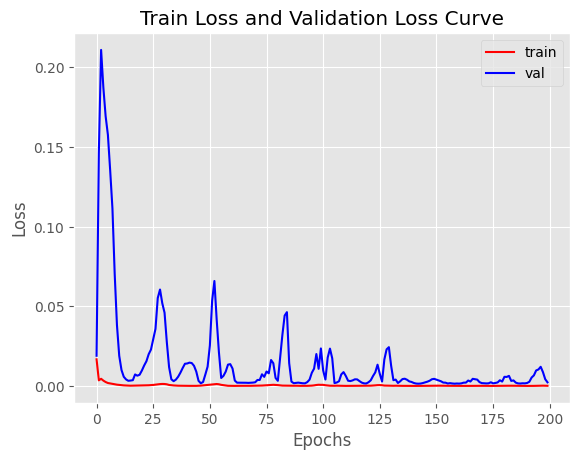

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.006059976663462937
RMSE = 0.07784585193485223
MAPE = 0.016530507188173976
R-Squared Score = 0.9940596051036115


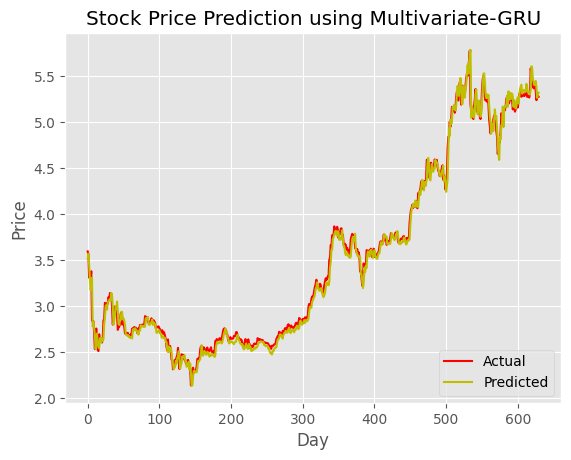

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
#model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model

# Model 4: Multivariate-5-LSTM

In [ ]:
import sys
import numpy as np
np.random.seed(1)
import random as rn
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'FPT.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()


In [ ]:
df.head()

,Open,High,Low,Close,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2006-12-14,17021.1,17021.1,17021.1,17021.1,4020000.0,NaN,NaN,NaN,17021.100000,17021.100000,0.000000,NaN,NaN,NaN,NaN
2006-12-15,17872.1,17872.1,17872.1,17872.1,3800000.0,NaN,NaN,NaN,17152.023077,17084.137037,67.886040,NaN,NaN,NaN,NaN
2006-12-18,18763.7,18763.7,18763.7,18763.7,3090000.0,NaN,NaN,NaN,17399.973373,17208.549108,191.424264,NaN,NaN,NaN,NaN
2006-12-19,19695.8,19695.8,19695.8,19695.8,1970000.0,NaN,NaN,NaN,17753.177469,17392.789915,360.387554,NaN,NaN,NaN,NaN
2006-12-20,20668.4,20668.4,20668.4,20668.4,3150000.0,NaN,NaN,NaN,18201.673243,17635.427699,566.245544,NaN,NaN,NaN,NaN


## Train Model


In [ ]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_4(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


##Plot chart

In [ ]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building

In [ ]:
# Extracting the series
series = df[['Close', 'High','Low' ,'RSI','MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)


(4438, 5)


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3777]         # Next 463 rows for validation
test_data = series.iloc[3778:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 5) (660, 5) (660, 5)


,Close,High,Low,RSI,MACD
Date,,,,,
2007-01-03,18236.9,18236.9,17831.6,55.905611,362.298879
2007-01-04,19128.4,19128.4,19128.4,59.420121,385.141305
2007-01-05,20060.5,20060.5,20060.5,59.712237,473.004274
2007-01-08,19857.9,20668.4,19857.9,55.172446,520.290596
2007-01-09,19857.9,20060.5,19857.9,50.840323,551.409048


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 5) (660, 5) (660, 5)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 199: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 199: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 197: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 197: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 188: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 188: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 142: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 142: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.8590463748824546
    timesteps        hl      lr  batch_size  num_epochs           MSE  \
0          30  [40, 35]  0.0010          32         200  7.379607e-01   
1          30  [40, 35]  0.0010          32         250  7.379607e-01   
2          30  [40, 35]  0.0010          64         200  5.546641e+00   
3          30  [40, 35]  0.0010          64         250  5.546641e+00   
4          30  [40, 35]  0.0001          32         200  6.024467e+04   
5          30  [40, 35]  0.0001          32         250  6.024467e+04   
6          30  [40, 35]  0.0001          64         200  9.339906e+04   
7          30  [40, 35]  0.0001          64         250  9.339906e+04   
8          40  [40, 35]  0.0010          32         200  1.410477e+00   
9          40  [40, 35]  0.0010          32         250  1.821439e+00   
10         40  [40, 35]  0.0010    

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 93: early stopping


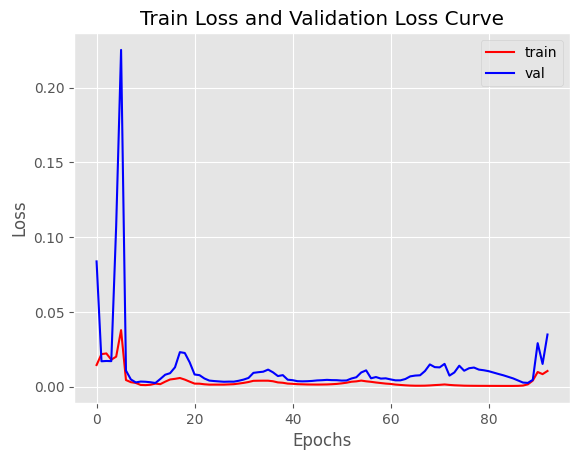

In [ ]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.022999084799727416
RMSE = 0.15165449152506963
MAPE = 0.16836445912133816
R-Squared Score = -1.0242580484796067


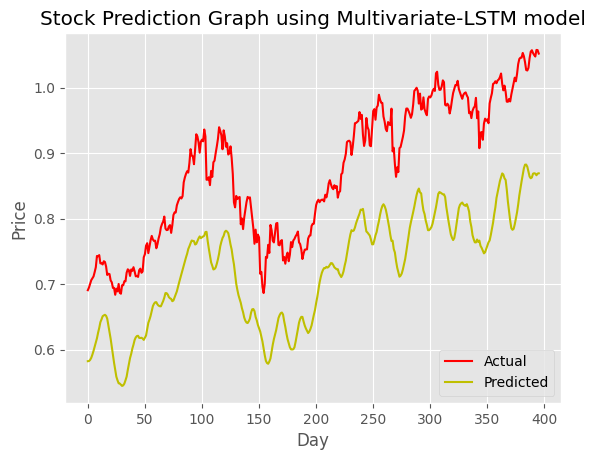

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [ ]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model

# Model 2: Multivariate-10-RNN








In [ ]:
import sys
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
print(tf.__version__)


2.8.4


In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'FPT.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


<Axes: >

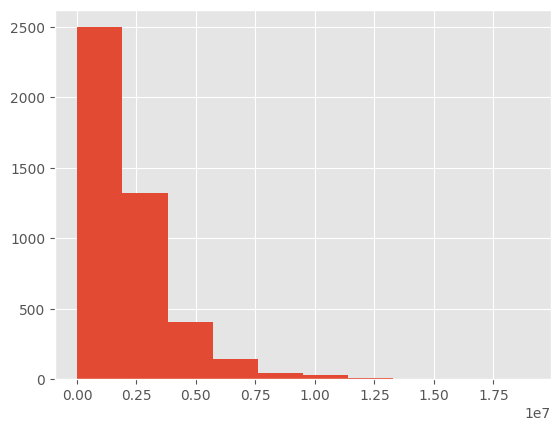

In [ ]:
# Distribution of Various Features
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
print(df.head())

               Open     High      Low    Close     Volume  CMA10  SMA10  \
Date                                                                      
2006-12-14  17021.1  17021.1  17021.1  17021.1  4020000.0    NaN    NaN   
2006-12-15  17872.1  17872.1  17872.1  17872.1  3800000.0    NaN    NaN   
2006-12-18  18763.7  18763.7  18763.7  18763.7  3090000.0    NaN    NaN   
2006-12-19  19695.8  19695.8  19695.8  19695.8  1970000.0    NaN    NaN   
2006-12-20  20668.4  20668.4  20668.4  20668.4  3150000.0    NaN    NaN   

            SMA50         EMA12         EMA26        MACD  RSI  CCI  %K  %D  
Date                                                                         
2006-12-14    NaN  17021.100000  17021.100000    0.000000  NaN  NaN NaN NaN  
2006-12-15    NaN  17152.023077  17084.137037   67.886040  NaN  NaN NaN NaN  
2006-12-18    NaN  17399.973373  17208.549108  191.424264  NaN  NaN NaN NaN  
2006-12-19    NaN  17753.177469  17392.789915  360.387554  NaN  NaN NaN NaN  
2006-1

## Train model

In [ ]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_2(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart

In [ ]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## Model building

In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()

(4398, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000
mean,29643.742315,29630.566028,29529.584218,29024.743204,29504.609364,52.633682,17.678274,51.392183,51.396899,176.678412
std,31274.875332,31236.131070,31069.718631,30189.110876,31016.800768,18.167921,113.220845,30.308797,28.422151,855.249843
min,2986.500000,3117.510000,3117.510000,3610.828000,3182.796692,0.000000,-406.085368,0.000000,0.000000,-5490.716253
25%,8456.300000,8430.035000,8430.035000,8427.797000,8441.449025,40.000082,-69.351132,25.863965,26.158605,-110.264521
50%,15115.650000,15090.825000,15090.825000,15160.657000,15096.772356,53.411203,27.410026,52.941692,53.526937,79.573681
75%,33934.900000,33832.405000,33784.512500,33239.248000,33743.266776,65.671250,99.022641,78.382767,77.137620,334.119082
max,146500.000000,139350.000000,139350.000000,134234.000000,139652.770083,100.000000,427.077681,100.000000,100.000000,5341.049997


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3116]           # First 2,160 rows for training
val_data = series.iloc[3117:3757]         # Next 463 rows for validation
test_data = series.iloc[3758:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3116, 10) (640, 10) (640, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
Date,,,,,,,,,,
2007-03-02,26139.5,25360.25,25219.56,22294.350,25321.826638,52.212428,72.154487,72.449391,57.823883,939.047857
2007-03-05,25734.2,25322.02,25466.77,22468.612,25385.268694,55.660224,63.551566,62.244435,58.843623,902.384637
2007-03-06,24501.1,25202.78,25477.19,22601.192,25249.242741,46.832023,-74.884026,31.196495,55.296774,765.009355
2007-03-07,24744.5,24982.23,25398.48,22720.808,25171.590012,46.165410,-27.423607,37.325008,43.588646,668.077617
2007-03-08,24338.8,24773.71,25360.25,22813.668,25043.468471,49.423027,-94.344003,27.109981,31.877161,552.156995


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3116, 10) (640, 10) (640, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 111: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 132: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 111: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 99: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 115: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 159: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 193: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 183: early stopping
Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.07177901299189432
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.067089  0.259016   
1          30  [40, 35]  0.0010          64         200  0.006183  0.078634   
2          30  [40, 35]  0.0001          32         200  0.016844  0.129784   
3          30  [40, 35]  0.0001          64         200  0.026597  0.163086   
4          40  [40, 35]  0.0010          32         200  0.265378  0.515148   
5          40  [40, 35]  0.0010          64         200  0.011180  0.105738   
6          40  [40, 35]  0.0001          32         200  0.015046  0.122663   
7          40  [40, 35]  0.0001          64         200  0.014876  0.121967   
8          50  [40, 35]  0.0010          32         200  0.005152  0.071779   
9          50  [40, 35]  0.0010          64   

In [ ]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 240: early stopping


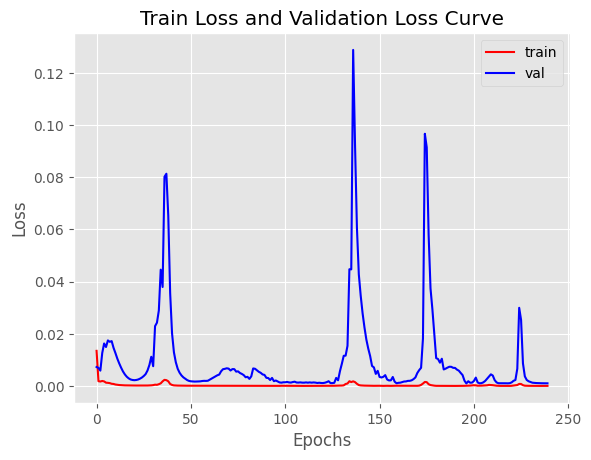

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0035020439996583217
RMSE = 0.05917807025966901
MAPE = 0.013117811151608896
R-Squared Score = 0.9952773209141781


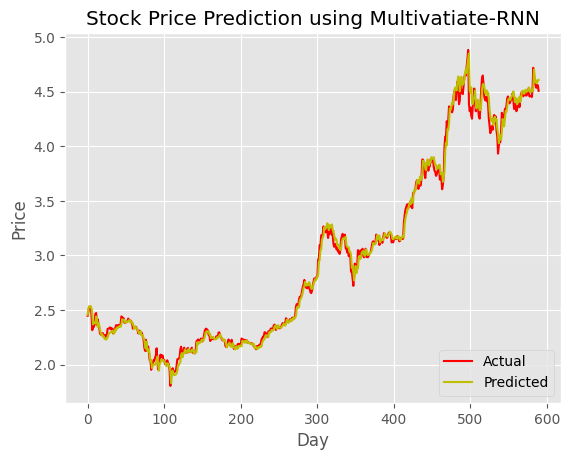

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

## Model building (8VAR)


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'CCI', '%K', '%D']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4398, 8)
               Close     CMA10     SMA10     SMA50          EMA12        CCI  \
Date                                                                           
2024-10-15  137000.0  137090.0  136270.0  132129.6  136463.420176  84.554679   
2024-10-16  136300.0  137020.0  136360.0  132483.6  136438.278610  36.938140   
2024-10-17  137000.0  136900.0  136660.0  132809.8  136524.697286  35.772358   
2024-10-18  137000.0  136160.0  136950.0  133109.8  136597.820780  55.612489   
2024-10-21  135500.0  135600.0  137090.0  133386.2  136428.925275  15.277778   

                   %K         %D  
Date                              
2024-10-15  40.816327  51.700680  
2024-10-16  33.673469  40.476190  
2024-10-17  40.816327  38.435374  
2024-10-18  37.634409  37.374735  
2024-10-21  21.505376  33.318704  


In [ ]:
series.describe()

,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
count,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000
mean,29643.742315,29630.566028,29529.584218,29024.743204,29504.609364,17.678274,51.392183,51.396899
std,31274.875332,31236.131070,31069.718631,30189.110876,31016.800768,113.220845,30.308797,28.422151
min,2986.500000,3117.510000,3117.510000,3610.828000,3182.796692,-406.085368,0.000000,0.000000
25%,8456.300000,8430.035000,8430.035000,8427.797000,8441.449025,-69.351132,25.863965,26.158605
50%,15115.650000,15090.825000,15090.825000,15160.657000,15096.772356,27.410026,52.941692,53.526937
75%,33934.900000,33832.405000,33784.512500,33239.248000,33743.266776,99.022641,78.382767,77.137620
max,146500.000000,139350.000000,139350.000000,134234.000000,139652.770083,427.077681,100.000000,100.000000


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3757]         # Next 463 rows for validation
test_data = series.iloc[3758:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 8) (640, 8) (640, 8)


,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
Date,,,,,,,,
2007-03-02,26139.5,25360.25,25219.56,22294.350,25321.826638,72.154487,72.449391,57.823883
2007-03-05,25734.2,25322.02,25466.77,22468.612,25385.268694,63.551566,62.244435,58.843623
2007-03-06,24501.1,25202.78,25477.19,22601.192,25249.242741,-74.884026,31.196495,55.296774
2007-03-07,24744.5,24982.23,25398.48,22720.808,25171.590012,-27.423607,37.325008,43.588646
2007-03-08,24338.8,24773.71,25360.25,22813.668,25043.468471,-94.344003,27.109981,31.877161


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 8) (640, 8) (640, 8)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 149: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 149: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 201: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 161: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 161: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 206: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 156: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 156: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 112: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 112: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 233: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 228: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Best Parameters: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE Score: 0.06592513345666996
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.040219  0.200546   
1          30  [40, 35]  0.0010          32         250  0.040219  0.200546   
2          30  [40, 35]  0.0010          64         200  0.021448  0.146451   
3          30  [40, 35]  0.0010          64         250  0.024293  0.155863   
4          30  [40, 35]  0.0001          32         200  0.038165  0.195358   
5          30  [40, 35]  0.0001          32         250  0.038165  0.195358   
6          30  [40, 35]  0.0001          64         200  0.215030  0.463714   
7          30  [40, 35]  0.0001          64         250  0.215030  0.463714   
8          40  [40, 35]  0.0010          32         200  0.016541  0.128611   
9          40  [40, 35]  0.0010          32   

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 206: early stopping


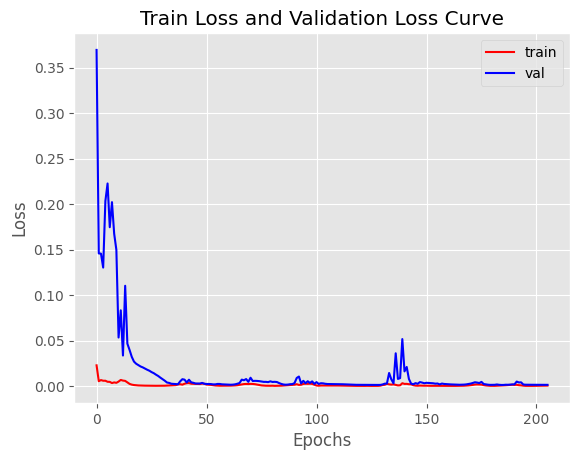

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.004346123221279745
RMSE = 0.06592513345666996
MAPE = 0.015084375386316958
R-Squared Score = 0.9940661408799467


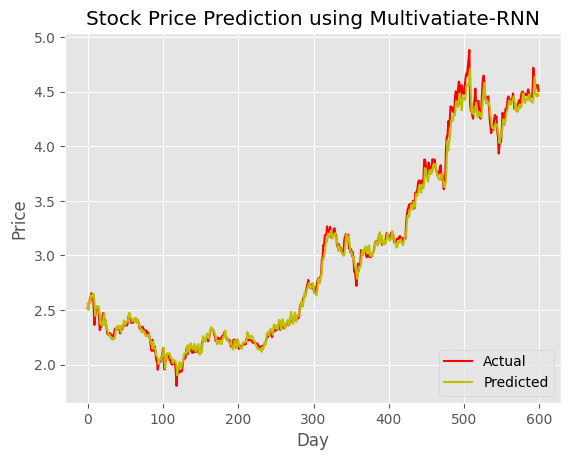

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 3: Multivariate-10-GRU


In [ ]:
import sys
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

##Data preprocessing

In [ ]:
url = 'FPT.csv'
df = pd.read_csv(url, parse_dates = True, index_col = 0)

In [ ]:
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
df.head()

,Open,High,Low,Close,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2006-12-14,17021.1,17021.1,17021.1,17021.1,4020000.0,NaN,NaN,NaN,17021.100000,17021.100000,0.000000,NaN,NaN,NaN,NaN
2006-12-15,17872.1,17872.1,17872.1,17872.1,3800000.0,NaN,NaN,NaN,17152.023077,17084.137037,67.886040,NaN,NaN,NaN,NaN
2006-12-18,18763.7,18763.7,18763.7,18763.7,3090000.0,NaN,NaN,NaN,17399.973373,17208.549108,191.424264,NaN,NaN,NaN,NaN
2006-12-19,19695.8,19695.8,19695.8,19695.8,1970000.0,NaN,NaN,NaN,17753.177469,17392.789915,360.387554,NaN,NaN,NaN,NaN
2006-12-20,20668.4,20668.4,20668.4,20668.4,3150000.0,NaN,NaN,NaN,18201.673243,17635.427699,566.245544,NaN,NaN,NaN,NaN


##Train Model


In [ ]:
def fit_model_3(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Evaluate Model


In [ ]:
def evaluate_model_3(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart


In [ ]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4398, 10)
               Close     CMA10     SMA10     SMA50          EMA12        RSI  \
Date                                                                           
2024-10-15  137000.0  137090.0  136270.0  132129.6  136463.420176  56.395349   
2024-10-16  136300.0  137020.0  136360.0  132483.6  136438.278610  55.747126   
2024-10-17  137000.0  136900.0  136660.0  132809.8  136524.697286  57.777778   
2024-10-18  137000.0  136160.0  136950.0  133109.8  136597.820780  57.062147   
2024-10-21  135500.0  135600.0  137090.0  133386.2  136428.925275  48.876404   

                  CCI         %K         %D         MACD  
Date                                                      
2024-10-15  84.554679  40.816327  51.700680  1491.115238  
2024-10-16  36.938140  33.673469  40.476190  1367.625890  
2024-10-17  35.772358  40.816327  38.435374  1311.129952  
2024-10-18  55.612489  37.634409  37.374735  1251.925101  
2024-10-21  15.277778  21.505376  33.318704  1071.614461  


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3116]           # First 2,160 rows for training
val_data = series.iloc[3117:3757]         # Next 463 rows for validation
test_data = series.iloc[3758:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3116, 10) (640, 10) (640, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
Date,,,,,,,,,,
2007-03-02,26139.5,25360.25,25219.56,22294.350,25321.826638,52.212428,72.154487,72.449391,57.823883,939.047857
2007-03-05,25734.2,25322.02,25466.77,22468.612,25385.268694,55.660224,63.551566,62.244435,58.843623,902.384637
2007-03-06,24501.1,25202.78,25477.19,22601.192,25249.242741,46.832023,-74.884026,31.196495,55.296774,765.009355
2007-03-07,24744.5,24982.23,25398.48,22720.808,25171.590012,46.165410,-27.423607,37.325008,43.588646,668.077617
2007-03-08,24338.8,24773.71,25360.25,22813.668,25043.468471,49.423027,-94.344003,27.109981,31.877161,552.156995


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3116, 10) (640, 10) (640, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 97: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 142: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 112: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 171: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 191: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 120: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 159: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 139: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 155: early stopping
Best Parameters: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.09009551840653758
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.017634  0.132793   
1          30  [40, 35]  0.0010          64         200  0.186233  0.431548   
2          30  [40, 35]  0.0001          32         200  0.285631  0.534445   
3          30  [40, 35]  0.0001          64         200  0.133505  0.365383   
4          40  [40, 35]  0.0010          32         200  0.008117  0.090096   
5          40  [40, 35]  0.0010          64         200  0.044060  0.209905   
6          40  [40, 35]  0.0001          32         200  0.219407  0.468409   
7          40  [40, 35]  0.0001          64         200  0.366349  0.605268   
8          50  [40, 35]  0.0010          32         200  0.047473  0.217883   
9          50  [40, 35]  0.0010          64   

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping


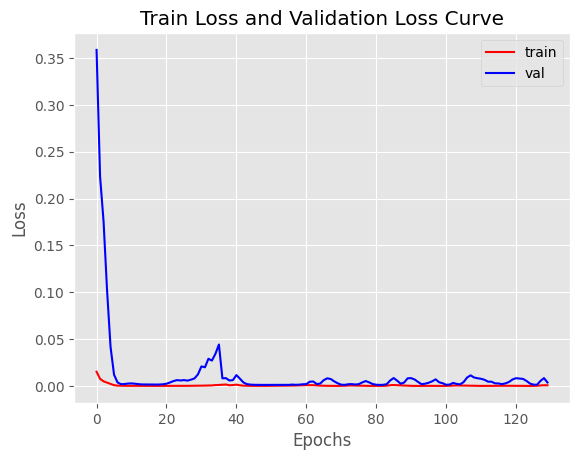

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.008117202436942753
RMSE = 0.09009551840653758
MAPE = 0.026610505425309194
R-Squared Score = 0.9889174021864044


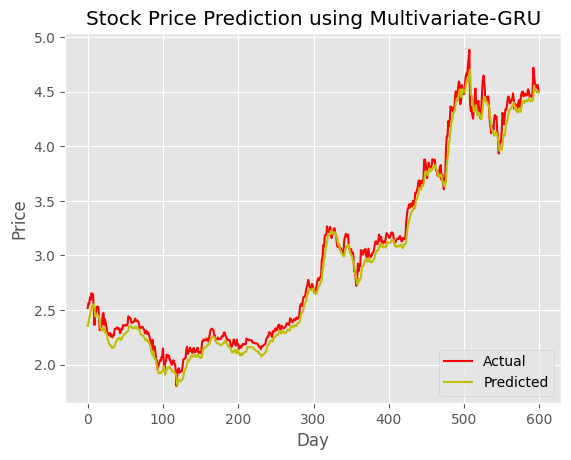

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
#model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model

## 8VAR


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'CCI', '%K', '%D']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4398, 8)
               Close     CMA10     SMA10     SMA50          EMA12        CCI  \
Date                                                                           
2024-10-15  137000.0  137090.0  136270.0  132129.6  136463.420176  84.554679   
2024-10-16  136300.0  137020.0  136360.0  132483.6  136438.278610  36.938140   
2024-10-17  137000.0  136900.0  136660.0  132809.8  136524.697286  35.772358   
2024-10-18  137000.0  136160.0  136950.0  133109.8  136597.820780  55.612489   
2024-10-21  135500.0  135600.0  137090.0  133386.2  136428.925275  15.277778   

                   %K         %D  
Date                              
2024-10-15  40.816327  51.700680  
2024-10-16  33.673469  40.476190  
2024-10-17  40.816327  38.435374  
2024-10-18  37.634409  37.374735  
2024-10-21  21.505376  33.318704  


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3757]         # Next 463 rows for validation
test_data = series.iloc[3758:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 8) (640, 8) (640, 8)


,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
Date,,,,,,,,
2007-03-02,26139.5,25360.25,25219.56,22294.350,25321.826638,72.154487,72.449391,57.823883
2007-03-05,25734.2,25322.02,25466.77,22468.612,25385.268694,63.551566,62.244435,58.843623
2007-03-06,24501.1,25202.78,25477.19,22601.192,25249.242741,-74.884026,31.196495,55.296774
2007-03-07,24744.5,24982.23,25398.48,22720.808,25171.590012,-27.423607,37.325008,43.588646
2007-03-08,24338.8,24773.71,25360.25,22813.668,25043.468471,-94.344003,27.109981,31.877161


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 8) (640, 8) (640, 8)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 140: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 140: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 166: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 166: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 164: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 164: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 163: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 163: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 193: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 193: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 167: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 167: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 112: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 112: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 235: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.14066620196213303
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.019787  0.140666   
1          30  [40, 35]  0.0010          32         250  0.019787  0.140666   
2          30  [40, 35]  0.0010          64         200  0.236220  0.486025   
3          30  [40, 35]  0.0010          64         250  0.236220  0.486025   
4          30  [40, 35]  0.0001          32         200  0.032854  0.181257   
5          30  [40, 35]  0.0001          32         250  0.038880  0.197181   
6          30  [40, 35]  0.0001          64         200  0.146015  0.382119   
7          30  [40, 35]  0.0001          64         250  0.110283  0.332089   
8          40  [40, 35]  0.0010          32         200  0.037217  0.192917   
9          40  [40, 35]  0.0010          32         250  0.037217  0.192

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 140: early stopping


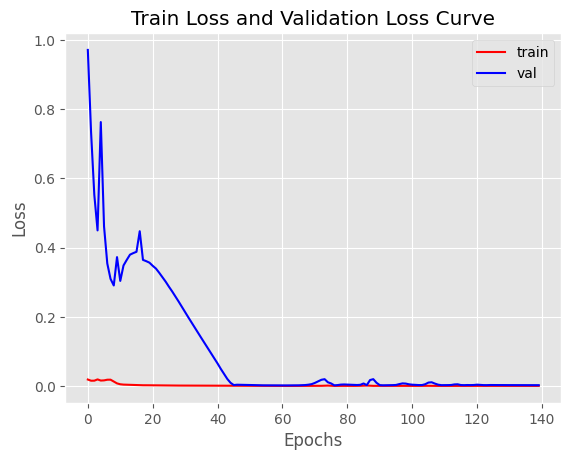

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0197869803744516
RMSE = 0.14066620196213303
MAPE = 0.03152178475642353
R-Squared Score = 0.9728157842012409


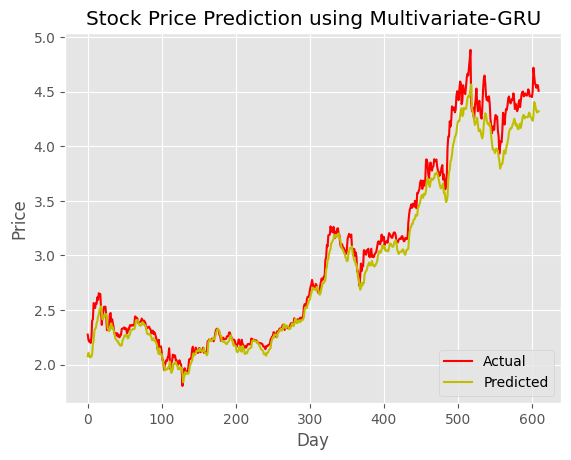

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 4: Multivariate-10-LSTM

In [ ]:
import sys
import numpy as np
np.random.seed(1)
import random as rn
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'FPT.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999753
High,0.999897
Low,0.999844
Close,1.000000
Volume,0.228569


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.450000e+03
mean     2.188017e+06
std      1.815084e+06
min      1.737000e+04
25%      9.591300e+05
50%      1.690000e+06
75%      2.820000e+06
max      1.897000e+07
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()


In [ ]:
df.head()

,Open,High,Low,Close,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2006-12-14,17021.1,17021.1,17021.1,17021.1,4020000.0,NaN,NaN,NaN,17021.100000,17021.100000,0.000000,NaN,NaN,NaN,NaN
2006-12-15,17872.1,17872.1,17872.1,17872.1,3800000.0,NaN,NaN,NaN,17152.023077,17084.137037,67.886040,NaN,NaN,NaN,NaN
2006-12-18,18763.7,18763.7,18763.7,18763.7,3090000.0,NaN,NaN,NaN,17399.973373,17208.549108,191.424264,NaN,NaN,NaN,NaN
2006-12-19,19695.8,19695.8,19695.8,19695.8,1970000.0,NaN,NaN,NaN,17753.177469,17392.789915,360.387554,NaN,NaN,NaN,NaN
2006-12-20,20668.4,20668.4,20668.4,20668.4,3150000.0,NaN,NaN,NaN,18201.673243,17635.427699,566.245544,NaN,NaN,NaN,NaN


## Train Model


In [ ]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_4(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


##Plot chart

In [ ]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building

In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()


(4398, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000
mean,29643.742315,29630.566028,29529.584218,29024.743204,29504.609364,52.633682,17.678274,51.392183,51.396899,176.678412
std,31274.875332,31236.131070,31069.718631,30189.110876,31016.800768,18.167921,113.220845,30.308797,28.422151,855.249843
min,2986.500000,3117.510000,3117.510000,3610.828000,3182.796692,0.000000,-406.085368,0.000000,0.000000,-5490.716253
25%,8456.300000,8430.035000,8430.035000,8427.797000,8441.449025,40.000082,-69.351132,25.863965,26.158605,-110.264521
50%,15115.650000,15090.825000,15090.825000,15160.657000,15096.772356,53.411203,27.410026,52.941692,53.526937,79.573681
75%,33934.900000,33832.405000,33784.512500,33239.248000,33743.266776,65.671250,99.022641,78.382767,77.137620,334.119082
max,146500.000000,139350.000000,139350.000000,134234.000000,139652.770083,100.000000,427.077681,100.000000,100.000000,5341.049997


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3116]           # First 2,160 rows for training
val_data = series.iloc[3117:3757]         # Next 463 rows for validation
test_data = series.iloc[3758:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3116, 10) (640, 10) (640, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
Date,,,,,,,,,,
2007-03-02,26139.5,25360.25,25219.56,22294.350,25321.826638,52.212428,72.154487,72.449391,57.823883,939.047857
2007-03-05,25734.2,25322.02,25466.77,22468.612,25385.268694,55.660224,63.551566,62.244435,58.843623,902.384637
2007-03-06,24501.1,25202.78,25477.19,22601.192,25249.242741,46.832023,-74.884026,31.196495,55.296774,765.009355
2007-03-07,24744.5,24982.23,25398.48,22720.808,25171.590012,46.165410,-27.423607,37.325008,43.588646,668.077617
2007-03-08,24338.8,24773.71,25360.25,22813.668,25043.468471,49.423027,-94.344003,27.109981,31.877161,552.156995


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3116, 10) (640, 10) (640, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 124: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 97: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 162: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 189: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 93: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 105: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 122: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.7951045767261116
    timesteps        hl      lr  batch_size  num_epochs           MSE  \
0          30  [40, 35]  0.0010          32         200  4.171902e+00   
1          30  [40, 35]  0.0010          64         200  6.321913e-01   
2          30  [40, 35]  0.0001          32         200  2.837851e+00   
3          30  [40, 35]  0.0001          64         200  1.904751e+00   
4          40  [40, 35]  0.0010          32         200  1.817971e+01   
5          40  [40, 35]  0.0010          64         200  2.479950e+00   
6          40  [40, 35]  0.0001          32         200  2.159571e+01   
7          40  [40, 35]  0.0001          64         200  1.392080e+01   
8          50  [40, 35]  0.0010          32         200  1.467555e+01   
9          50  [40, 35]  0.0010          64         200  2.315423e+00   
10         50  [40, 35]  0.0001   

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 124: early stopping


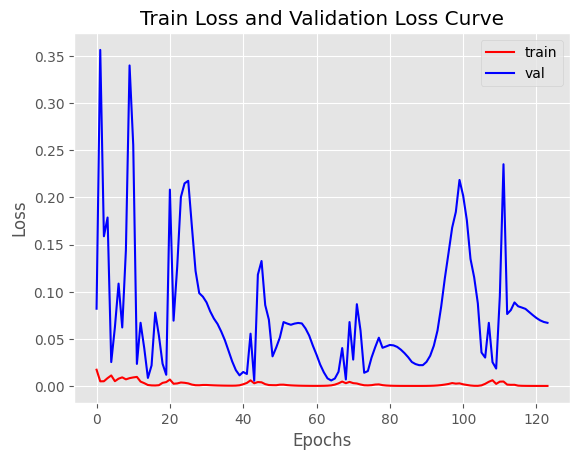

In [ ]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.632191287930809
RMSE = 0.7951045767261116
MAPE = 0.20298718393245319
R-Squared Score = 0.1314680627370427


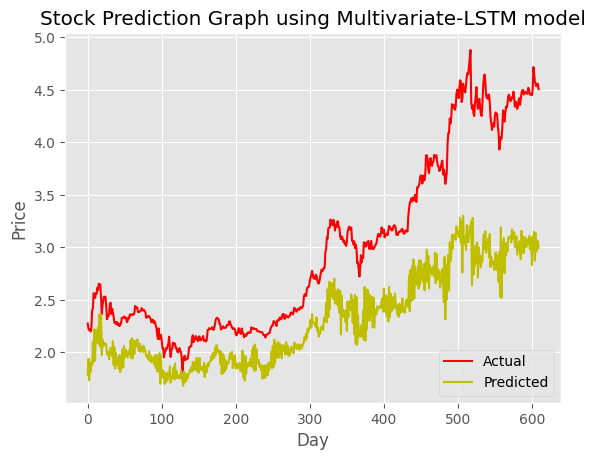

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [ ]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model

## 8 VAR


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'CCI', '%K', '%D']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4398, 8)
               Close     CMA10     SMA10     SMA50          EMA12        CCI  \
Date                                                                           
2024-10-15  137000.0  137090.0  136270.0  132129.6  136463.420176  84.554679   
2024-10-16  136300.0  137020.0  136360.0  132483.6  136438.278610  36.938140   
2024-10-17  137000.0  136900.0  136660.0  132809.8  136524.697286  35.772358   
2024-10-18  137000.0  136160.0  136950.0  133109.8  136597.820780  55.612489   
2024-10-21  135500.0  135600.0  137090.0  133386.2  136428.925275  15.277778   

                   %K         %D  
Date                              
2024-10-15  40.816327  51.700680  
2024-10-16  33.673469  40.476190  
2024-10-17  40.816327  38.435374  
2024-10-18  37.634409  37.374735  
2024-10-21  21.505376  33.318704  


In [ ]:
# Splitting dataset by row counts
train_data = series.iloc[:3117]           # First 2,160 rows for training
val_data = series.iloc[3117:3757]         # Next 463 rows for validation
test_data = series.iloc[3758:]            # Last 463 rows for testing

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(3117, 8) (640, 8) (640, 8)


,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
Date,,,,,,,,
2007-03-02,26139.5,25360.25,25219.56,22294.350,25321.826638,72.154487,72.449391,57.823883
2007-03-05,25734.2,25322.02,25466.77,22468.612,25385.268694,63.551566,62.244435,58.843623
2007-03-06,24501.1,25202.78,25477.19,22601.192,25249.242741,-74.884026,31.196495,55.296774
2007-03-07,24744.5,24982.23,25398.48,22720.808,25171.590012,-27.423607,37.325008,43.588646
2007-03-08,24338.8,24773.71,25360.25,22813.668,25043.468471,-94.344003,27.109981,31.877161


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3117, 8) (640, 8) (640, 8)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 116: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 116: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 89: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 89: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 208: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 157: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 157: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 238: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 187: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 187: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 245: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.26039484974290406
    timesteps        hl      lr  batch_size  num_epochs            MSE  \
0          30  [40, 35]  0.0010          32         200       0.255986   
1          30  [40, 35]  0.0010          32         250       0.255986   
2          30  [40, 35]  0.0010          64         200       0.067805   
3          30  [40, 35]  0.0010          64         250       0.067805   
4          30  [40, 35]  0.0001          32         200      31.318095   
5          30  [40, 35]  0.0001          32         250      46.284625   
6          30  [40, 35]  0.0001          64         200    1283.523527   
7          30  [40, 35]  0.0001          64         250    1283.523527   
8          40  [40, 35]  0.0010          32         200       0.489559   
9          40  [40, 35]  0.0010          32         250       0.489559   
10         40  [40, 35]

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 89: early stopping


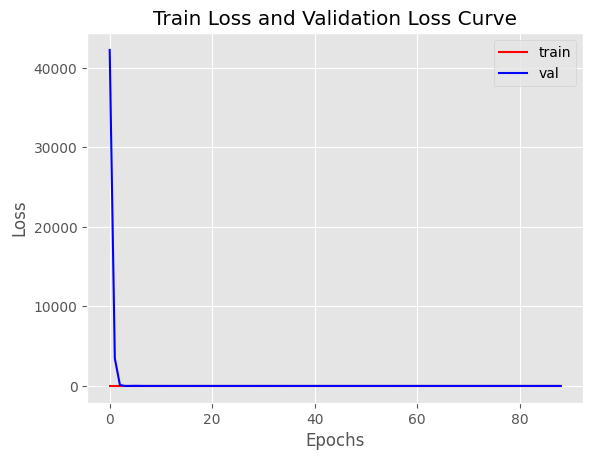

In [ ]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.06780547777262959
RMSE = 0.26039484974290406
MAPE = 0.0853831615888639
R-Squared Score = 0.9068458802087324


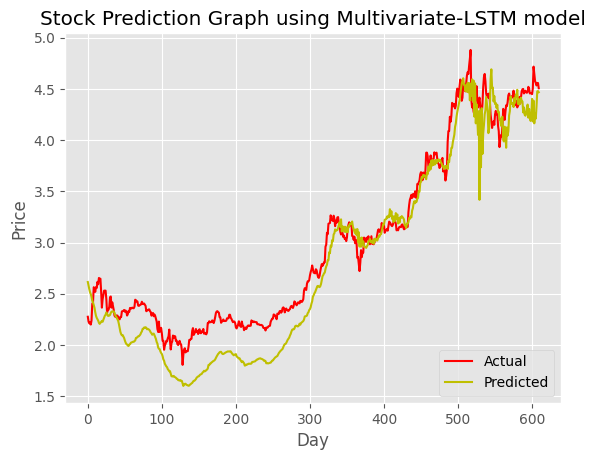

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [ ]:
del model